pip install --force-reinstall tensorflow

# SOMMAIRE

### Introduction

L'objectif de ce projet est d'entrainer un CNN capable de classer les images en fonction de la race du chien présent sur l'image, en utilisant notamment du Transfert Learning.  
Le dataset utilisé est le [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) .


1. [Imports et chemins](#-1.-Imports-et-chemins)
2. [Observation des données](#-2.-Observation-des-données)
3. [Preprocessing](#-3.-Preprocessing)
4. [Modèles CNN](#-4.-Modèles-CNN)

## 1. Imports et chemins

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Observation
from wordcloud import WordCloud

# Preprocessing
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
PATH_INPUT = "/Users/alexandremonod/Python/OC_ML/projet_6_classer_des_images/input"
PATH_OUTPUT = "/Users/alexandremonod/Python/OC_ML/projet_6_classer_des_images/output"
PATH_FIGURES = "/Users/alexandremonod/Python/OC_ML/projet_6_classer_des_images/output/figures"

In [3]:
# Unix : Il ne faut pas prendre en compte les fichiers cachés
list_breeds = [f for f in os.listdir(PATH_INPUT + "/Images") if not f.startswith('.')]

## 2. Observation des données

In [4]:
print(f"Nb de catégories/d'espèces de chiens :", len(list_breeds))

Nb de catégories/d'espèces de chiens : 120


In [5]:
# Production d'un df
 
df = pd.DataFrame(list_breeds, columns=['Id_name_breed'])
df['breed_name']=df['Id_name_breed'].apply(lambda x: x.split('-')[1])
df['Id']=df['Id_name_breed'].apply(lambda x: x.split('-')[0])

nb_pic=[]
for name in df.Id_name_breed:
   nb_pic.append(len(os.listdir(f"{PATH_INPUT}//Images" + "/" + name)))

df['nb_pic']=nb_pic

print("Nb total d'images:", df["nb_pic"].sum())

Nb total d'images: 20580


In [6]:
df.head(3)

Id_name_breed                breed_name         Id  \
0             n02097658-silky_terrier             silky_terrier  n02097658   
1        n02092002-Scottish_deerhound        Scottish_deerhound  n02092002   
2  n02099849-Chesapeake_Bay_retriever  Chesapeake_Bay_retriever  n02099849   

   nb_pic  
0     183  
1     232  
2     167

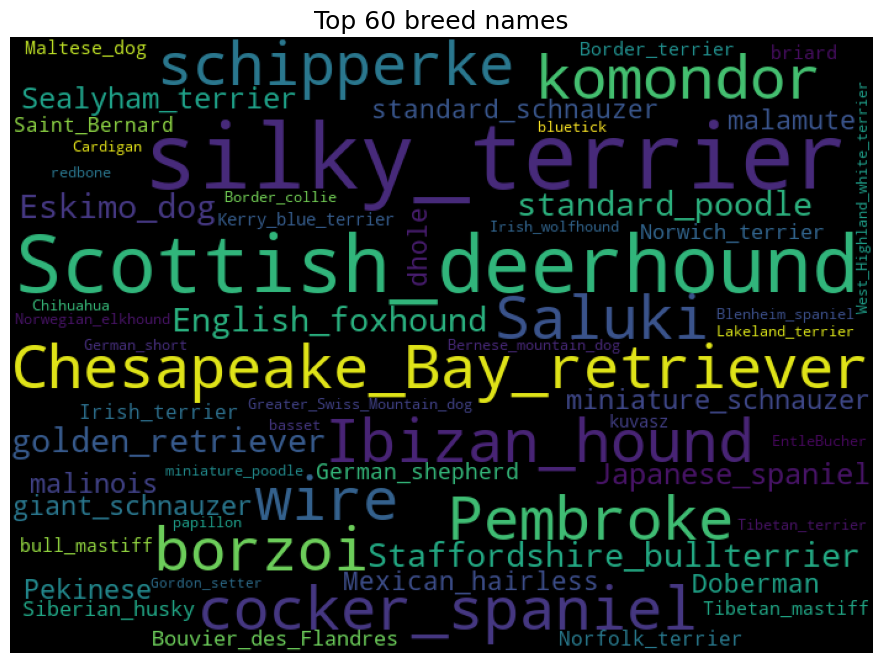

In [7]:
fig = plt.figure(1, figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=700, height=500,
                      background_color="black",max_words=60, relative_scaling=1,
                      normalize_plurals=False).generate(" ".join(df.breed_name))

ax.imshow(wordcloud)
ax.axis("off")
plt.title("Top 60 breed names", fontsize=18)
plt.show()

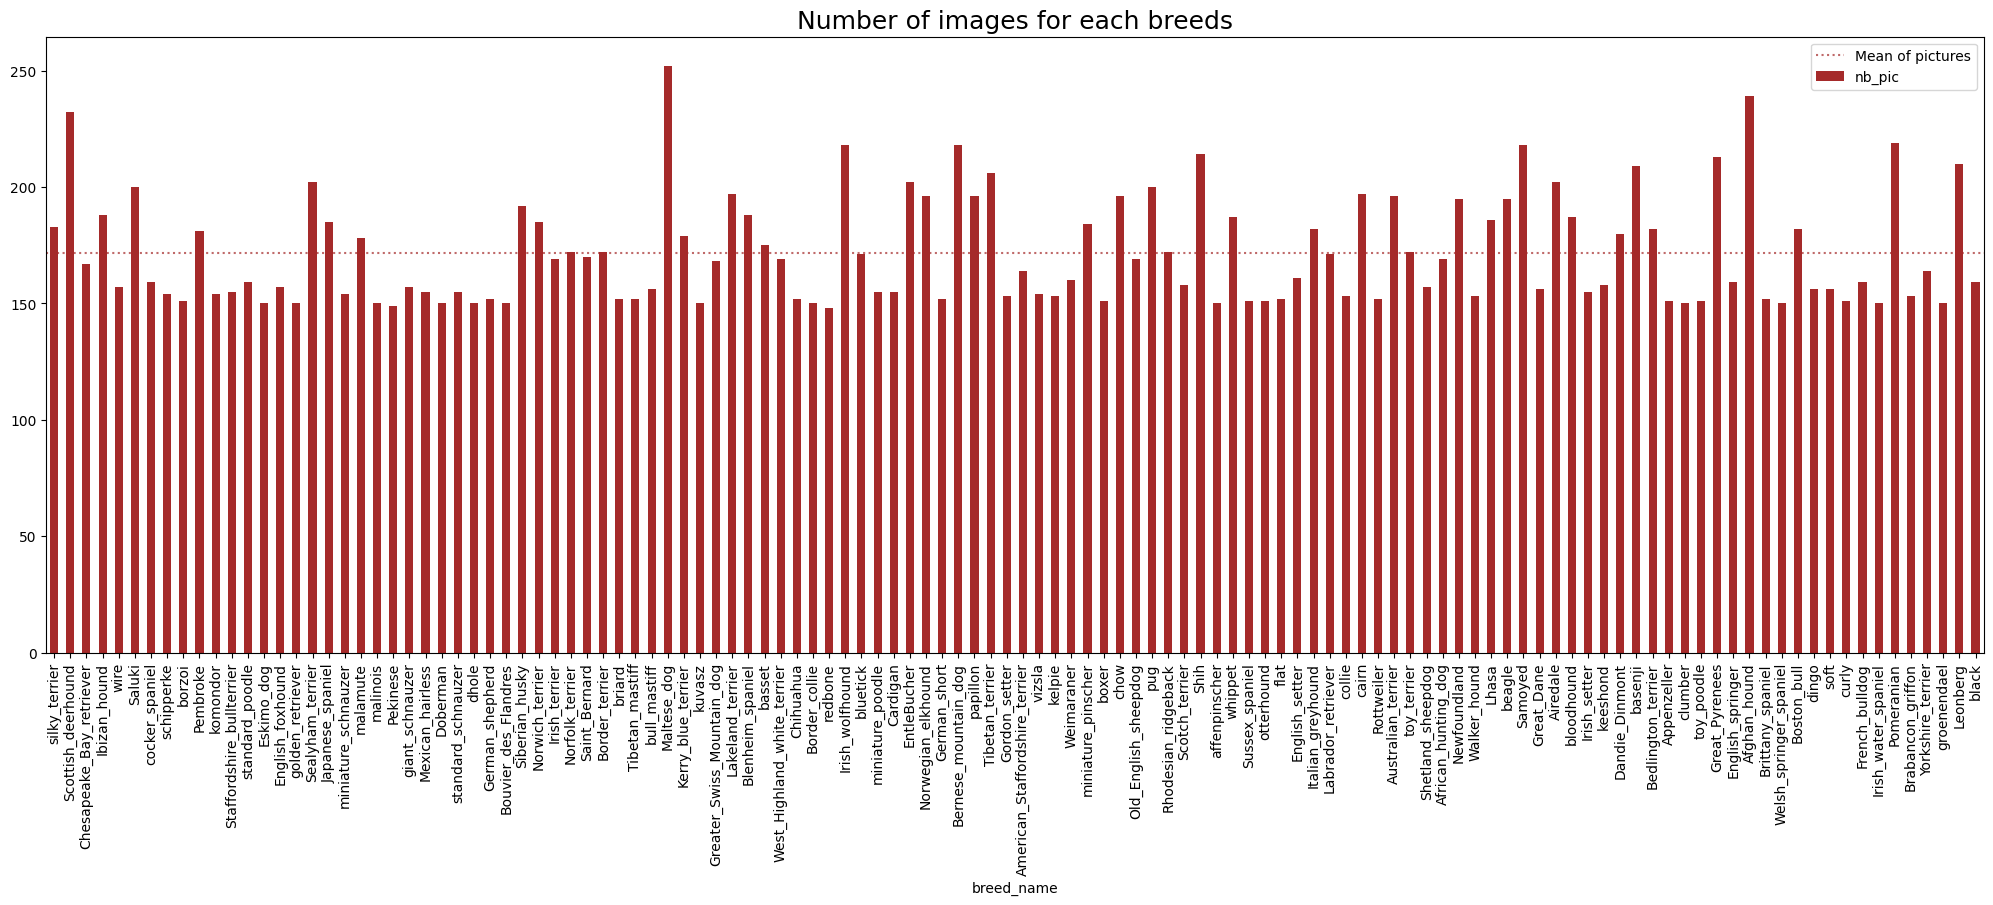

Le nb moyen d'images par classe est de 171.5
Le nb d'images par classe varie entre 148 et 252


In [8]:
fig, ax = plt.subplots(1, 1, figsize=(25,8))
df.plot(x='breed_name',kind="bar", color='brown',legend=False,ax=ax)
ax.axhline(df["nb_pic"].mean(),
           color='brown', alpha=.7,
           linestyle=':',
           label="Mean of pictures")
plt.title("Number of images for each breeds",
          color='k', fontsize=18)
plt.legend()
plt.show()

print("Le nb moyen d'images par classe est de", df["nb_pic"].mean())
print("Le nb d'images par classe varie entre", df["nb_pic"].min(), "et", df["nb_pic"].max())

In [9]:
import matplotlib.image as mpimg

In [10]:
#list of directories 
path_list=[]
for classe in df['Id_name_breed'].values:
    images = os.listdir(f"{PATH_INPUT}//Images" + "/" + classe)
    for i in range(len(images)):
        path_list.append(f"{PATH_INPUT}//Images"+"/"+ classe +"/"+images[i])
        
#list of images shape        
ds_img=[]
for path in path_list:
    ds_img.append(mpimg.imread(path).shape)

#data frame of results    
ds_img = pd.DataFrame(ds_img, index = path_list,columns=['heigth','width','color'])
#list of breed which corespoonds to each path      
y=[]
for j in range(len(list_breeds)):
   for k in range(df.nb_pic.values[j]):
      y.append(df.breed_name.values[j])
ds_img['breed_name']=y

In [11]:
ds_img.sample(10)

heigth  width  color  \
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     500    375      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     372    591      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     357    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     375    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     375    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     332    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     375    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     375    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     440    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     246    250      3   

                                                             breed_name  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...      Irish_wolfhound  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...             keeshond  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...       Border_terrier  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...  Rhodesian_ridgeback  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...   standard_schnauzer  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     English_springer  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     English_springer  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...   Bedlington_terrier  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...               borzoi  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...        affenpinscher

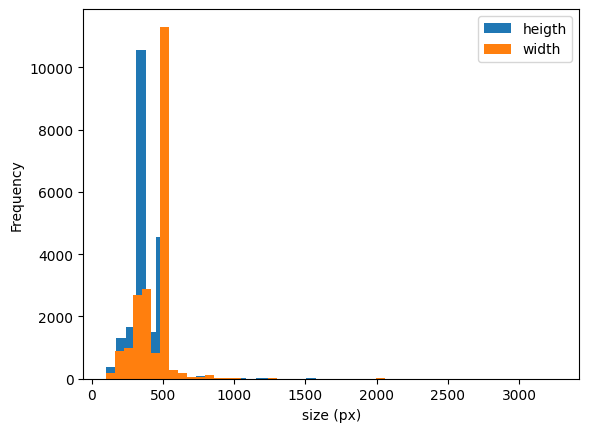

Larguer et hauteur moyennes par image :  (385.86, 442.53)


In [12]:
ds_img['heigth'].plot.hist(bins=35, alpha=1)
ds_img['width'].plot.hist(bins=50, alpha=1)
plt.xlabel('size (px)')
plt.legend(['heigth','width'])
plt.show()
print("Larguer et hauteur moyennes par image : ", (round(ds_img['heigth'].mean(),2),round(ds_img['width'].mean(),2)))

In [13]:
ds_img['color'].value_counts().values[0]

20579

In [14]:
# Obtenir les fréquences des couleurs dans le DataFrame
color_counts = ds_img['color'].value_counts().reset_index()
color_counts.columns = ['Couleur', 'Fréquence']

# Trier les couleurs par ordre décroissant de fréquence
color_counts = color_counts.sort_values(by='Fréquence', ascending=False)

print("Fréquence des couleurs dans le dataset :")
print(color_counts)

Fréquence des couleurs dans le dataset :
   Couleur  Fréquence
0        3      20579
1        4          1


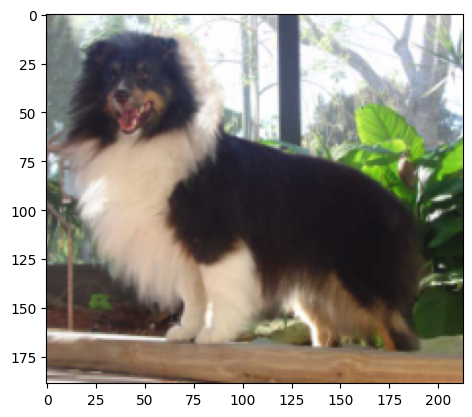

In [15]:
image_color_4 = ds_img[ds_img.color==4].index[0]
img4 = mpimg.imread(image_color_4)
plt.imshow(img4)

L'indice de couleur exprime en fait le niveau de transparence de l'image. Une seule est à 4, on remarque que c'est une image avec une transparence forte dans la partie supérieure droite.

(-0.5, 499.5, 413.5, -0.5)

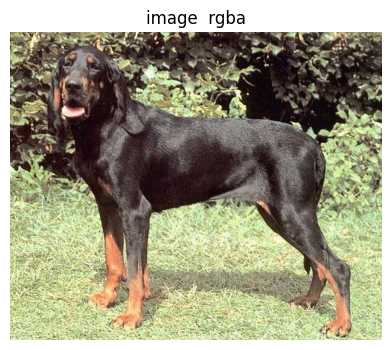

In [16]:
#Affichage d'une image au hasard
plt.fig = plt.figure(figsize=(10,4))
idx = ds_img[ds_img.color==3].index[random.randint(0,len(ds_img[ds_img.color==3]))]
img4 = mpimg.imread(idx)
plt.imshow(img4)
plt.title("image  rgba")
plt.axis('off')

Regardons quelques exemples des images par races disponibles dans notre base d'étude :

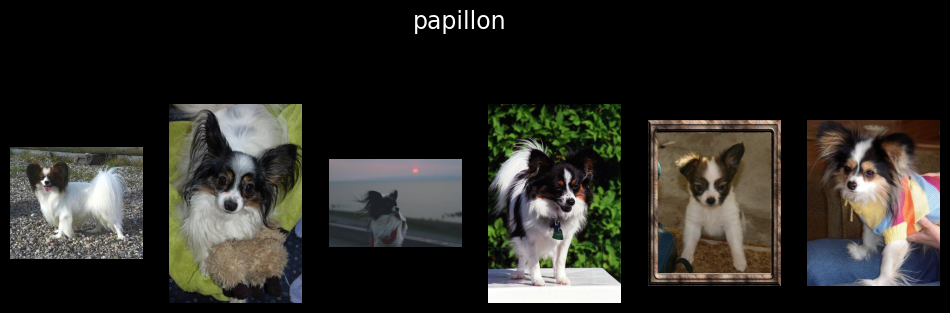

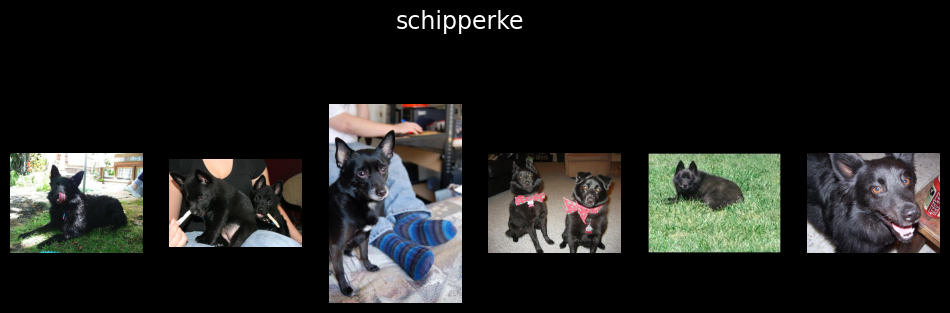

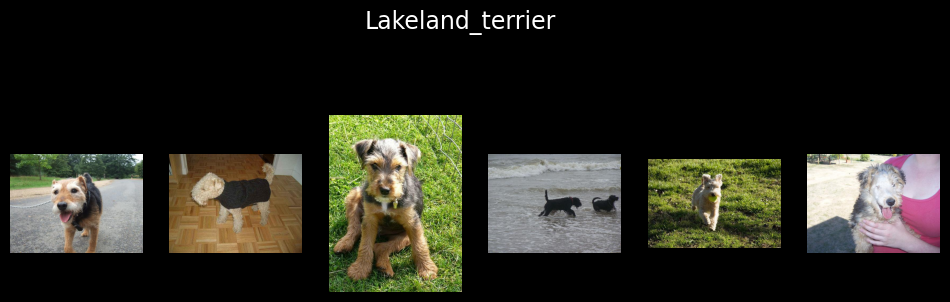

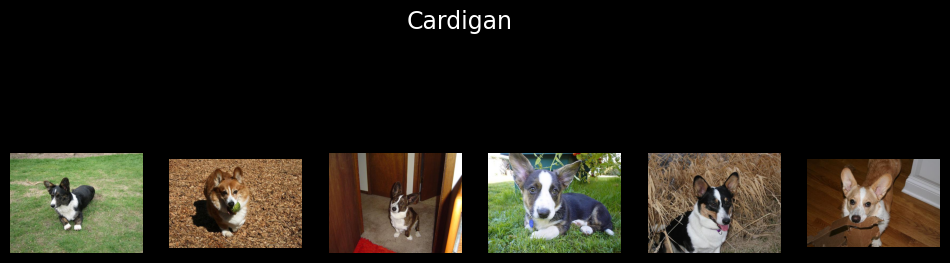

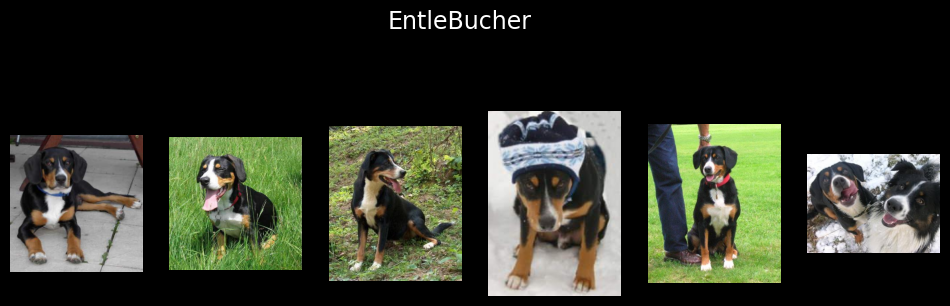

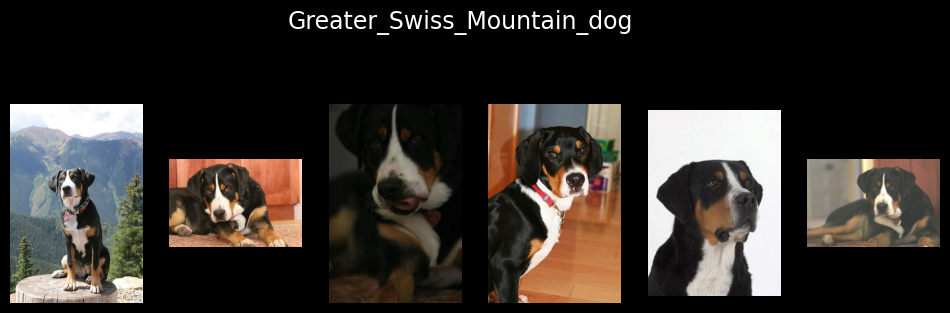

In [17]:
plt.style.use('dark_background')

Num = 6
breed_id_sample = np.random.choice(df['Id_name_breed'].values,Num)
for classe in breed_id_sample:
   images = os.listdir(f"{PATH_INPUT}//Images" + "/" + classe)[:Num]
   fig = plt.figure(figsize=(12,4))
   plt.suptitle("{}".format(classe.split("-")[1]), color="w", fontsize=17) 
   for i in range(Num):
        img = mpimg.imread(f"{PATH_INPUT}//Images"+"/"+ classe +"/"+images[i])
        plt.subplot(1, Num, i+1)
        plt.imshow(img)
        plt.axis('off')  
   plt.show()

La dimension des images n'est pas uniforme ; or le modèle CNN exige une taille unique pour toutes les données. Il faut donc redimensionner les images à une dimension unique. Nous choisissons la dimenstion standard 300*300.

Nous allons ainsi effectuer un ensemble de transformation sur notre base des images. Notamment, la redimensinnement, l'égalisation, le débruitage et le blanchiment.

## 3. Preprocessing

### 1.2.1 Egalisation d'histogramme

Il s'agit de mieux répartir l'intensité lumineuse dans l'ensemble de l'image : les images ternes seront éclairées, les images claires seront assombries.  Cela revient à égaliser un histogramme.  
  
![Histogramme](https://docs.opencv.org/4.x/histogram_equalization.png)  
  
Pour des images couleur, il faut procéder couleur par couleur : red, green, puis blue.

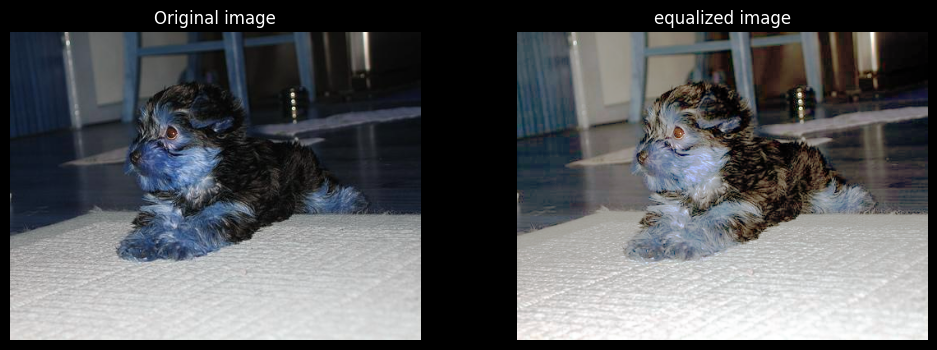

In [18]:
random_path = ds_img.index[np.random.randint(len(ds_img))]
image = cv2.imread(random_path)

# Equalization
r_image, g_image, b_image = cv2.split(image)
r_image_eq = cv2.equalizeHist(r_image)
g_image_eq = cv2.equalizeHist(g_image)
b_image_eq = cv2.equalizeHist(b_image)
image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
cmap_val = None

# Show both images
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off') 
plt.imshow(image)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.axis('off') 
plt.imshow(image_eq)
plt.title("equalized image")
plt.show()           

### 1.2.2 Débruitage de l'image

Une image peut être "bruitée", c-à-d avoir des pixels indésirables, du grain, en raison de la mauvaise qualité de l'appareil ou de conditions climatiques défavorables.  
Pour débruiter, OpenCV calcule les moyennes de blocs de pixels similaires (blocs avec les mêmes variations de couleur, les mêmes motifs...) et corrgie ensuite chaque bloc individuel. Cela homogénéise, enlève les détails spécifiques de chaque bloc mais limite aussi les "erreurs" du bruit.

Pour la méthode "fastNlMeansDenoisingColored", j'utilise des paramètres par défaut, retrouvés dans différentes explications sur le sujet, notamment sur la documentation [https://docs.opencv.org/4.x/d1/d79/group__photo__denoise.html].

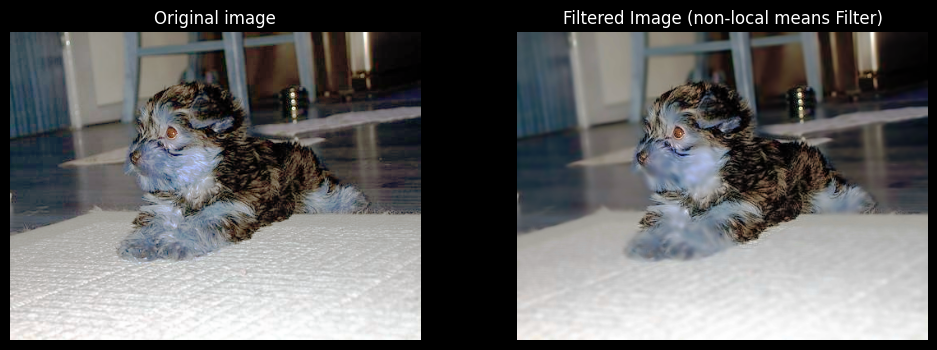

In [19]:
# Apply non-local means filter on test img
img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,21,7)
# Show both img
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off') 
plt.imshow(image_eq)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.axis('off') 
plt.imshow(img_nlf)
plt.title("Filtered Image (non-local means Filter)")
plt.show()

### 1.2.3 Whitening

Le but du whitening est de supprimer la corrélation entre les pixels.  
Le whitening, contrairement à ce que son nom indique, n'aboutit pas forcément à une image en noir et blanc.

Le processus de whitening peut être résumé comme suit :

Calcul de la matrice de covariance : Tout d'abord, on calcule la matrice de covariance à partir des données d'entrée. La matrice de covariance représente les relations statistiques entre les différentes caractéristiques de l'ensemble de données.

Décomposition en valeurs propres et vecteurs propres : Ensuite, on effectue une décomposition en valeurs propres et vecteurs propres de la matrice de covariance. Cela permet de déterminer les directions principales (vecteurs propres) le long desquelles les données sont les plus étendues et les valeurs propres indiquent les variances associées à ces directions.

Normalisation des vecteurs propres : Les vecteurs propres sont normalisés pour avoir une longueur unitaire, ce qui permet d'obtenir une base orthonormée.

Réduction de la corrélation : Les données d'entrée sont projetées sur cette nouvelle base orthonormée, ce qui les rend décorrélées. Cela signifie que les nouvelles caractéristiques sont statistiquement indépendantes les unes des autres.

Ajustement de l'échelle : Enfin, les caractéristiques sont ajustées en échelle pour avoir une variance unitaire, ce qui est également appelé mise à l'échelle unitaire.

In [20]:
# Test ChatGPT

In [21]:
def whitening(image):
    # Convert the image to floating-point type and normalize to [0, 1]
    image = image.astype(np.float32) / 255.0

    # Calculate the covariance matrix of the image channels
    cov_matrix = np.cov(image.reshape(-1, 3), rowvar=False)

    # Perform the eigendecomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvectors in decreasing order of eigenvalues
    order = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, order]

    # Whitening transformation: Xwhitened = (X - mean) * V * D^(-1/2)
    mean = np.mean(image, axis=(0, 1))
    whitened_image = np.dot(image - mean, eigenvectors) / np.sqrt(eigenvalues + 1e-5)

    # Scale the whitened image to the range [0, 255]
    whitened_image = (whitened_image - np.min(whitened_image)) / (np.max(whitened_image) - np.min(whitened_image))
    whitened_image = (whitened_image * 255).astype(np.uint8)

    return whitened_image

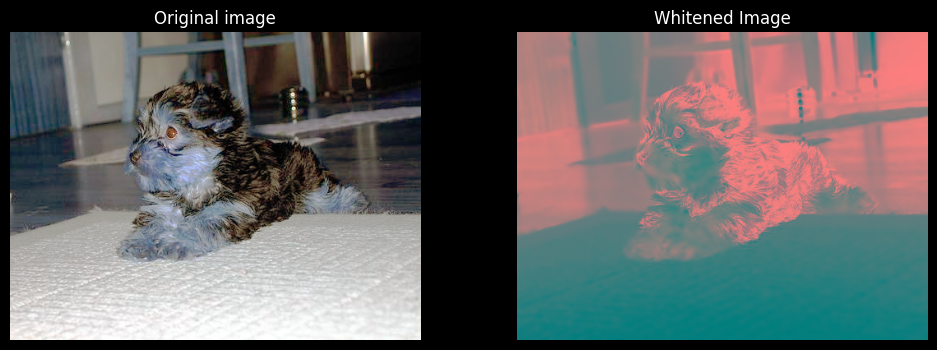

In [22]:
whitened_image = whitening(img_nlf)
# Show both img
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off') 
plt.imshow(image_eq)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.axis('off') 
plt.imshow(whitened_image,cmap='Greys')
plt.title("Whitened Image")
plt.show()

### 1.2.4 Augmentation de données

L'objectif est de produire de nouvelles images depuis des images existantes afiin d'augmenter la base de données.  
Il s'agit d'appliquer des transformations géométriques aléatoires : translations, rotations, mirroring, ...

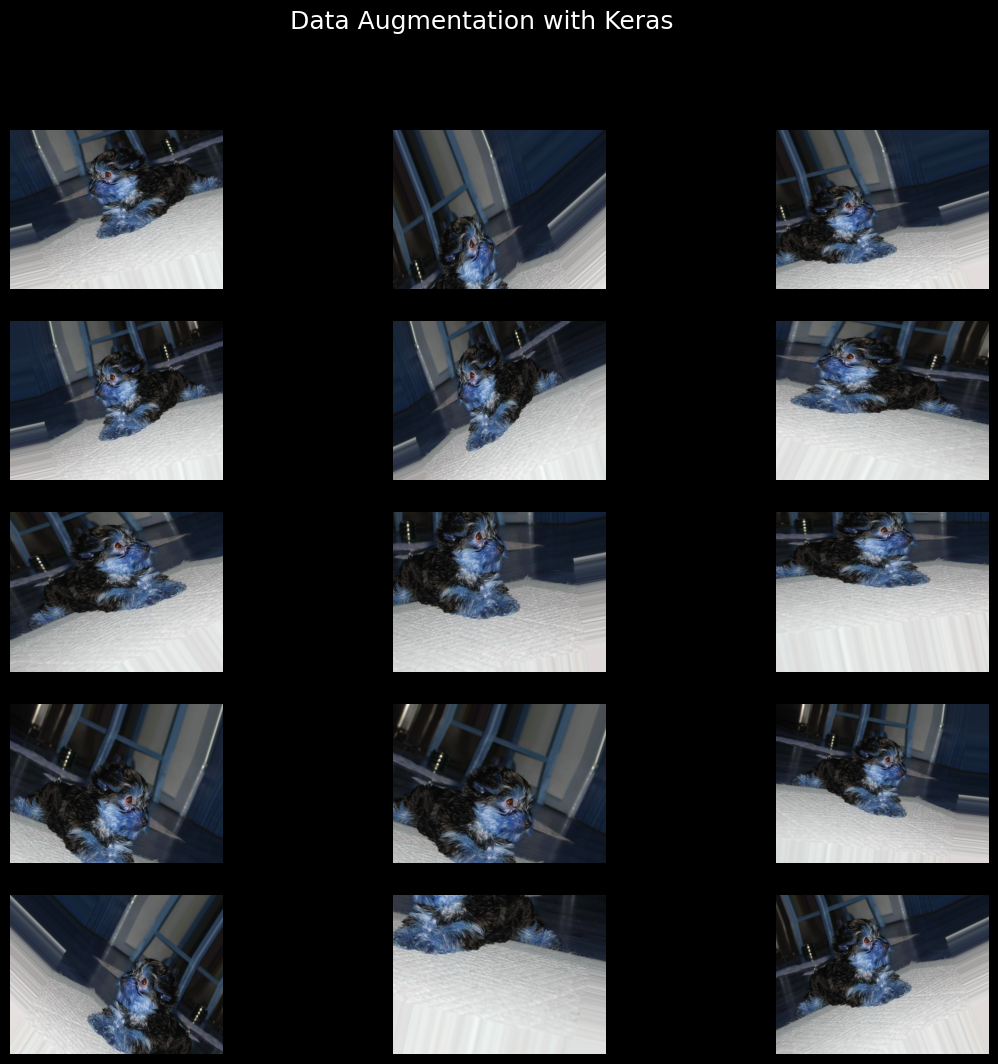

In [23]:
# Création du générateur d'images
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        fill_mode='nearest')

# Convert an image to array
x = image.reshape((1,) + image.shape)

# Generate batches of augmented images from `x`
fig = plt.figure(figsize=(14,12))
for i, batch in enumerate(datagen.flow(x, batch_size=1)):

    # We only want the first 15 batches, so break the loop after that
    if i == 15:
        break

    # Get the subplot for the current batch and display it
    ax = fig.add_subplot(5, 3, i+1)
    ax.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))

    plt.axis('off') 


plt.suptitle("Data Augmentation with Keras", fontsize=18)
plt.show()

## 4. Modèles CNN

Plusieurs paramètres doivent être définis pour entrainer un modèle CNN : 
- __le type de fonction d'activation__ : elle introduit de la non-linéarité dans le modèle et détermine l'output d'un neurone dans le réseau
- __l'algorithme d'optimisation__ : méthode utilisée pour ajuster les poids du réseau afin de minimiser la fonction de coût
- __le nb de filtres__ (sur la couche de convolution)/nb de kernel : chaque filtre est capable de détecter une caractéristique spécifique dans l'image (par exemple, les bords, les couleurs, etc.). Un nombre plus élevé de filtres permet au réseau d'apprendre une plus grande variété de caractéristiques, mais augmente également la complexité du modèle.
- __le Wind__ : taille de la fenêtre d'entrée sur laquelle le filtre de convolution est appliqué. Par exemple, une taille de fenêtre de 3 signifie que le filtre est appliqué sur des carrés de 3x3 pixels à la fois. La taille de la fenêtre influence le niveau de détail que le réseau peut apprendre : une taille de fenêtre plus petite permet de capturer des détails fins, tandis qu'une taille plus grande permet de capturer des caractéristiques plus globales.
- __le nb d'Epochs__ : nb de fois l'ensemble du jeu de données est passé au travers du réseau neuronal

Il va falloir déterminer quels sont les paramètres les plus performants dans notre cas.

Les mesures classiques d'évaluation d'un modèle CNN sont :
- __Accuracy__ : indique la performance du modèle à travers la proportion d'observations correctement classées par rapport à toutes les observations
- __Loss__ : mesure la manière dont le modèle s'ajuste aux données. Une perte élevée indique un surajustement, une perte faible est bon signe.

### Train-test sur 5 races

In [40]:
NB_BREEDS = 5

In [25]:
def preprocessing(uri_list,input_shape):
    """Preprocessing of images for convolutional neural network.
    Equalization, Denoising and transformation of the image into Array. 
    ------------------
    param:
    uri_list: 
    list of images directories
    input_shape: 
    (width, heigth) size of the image  for target resizing
    """
    img_list=[]
    for uri in uri_list:
            # Read image
            image = cv2.imread(uri)
            # Resize image
            image = cv2.resize(image, input_shape)
            # Equalization
            r_image, g_image, b_image = cv2.split(image)
            r_image_eq = cv2.equalizeHist(r_image)
            g_image_eq = cv2.equalizeHist(g_image)
            b_image_eq = cv2.equalizeHist(b_image)
            image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
            # Apply non-local means filter 
            img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,7,21)
            img_nlf = whitening(img_nlf)
            # Append lists of labels and image
            img_list.append(img_nlf)
            #labels = ds_img.bread_name[0:tot_nb_img]
        
  
    return np.array(img_list)

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [51]:
uri_list=ds_img.index.values[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]
X = preprocessing(uri_list, (300,300))
y = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

# Convert data in numpy array
y = np.array(y)

# Dans un modèle CNN, les labels doivent être numériques. Il faut les encoder.
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [28]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y

In [ ]:
y_ = y.astype(str)

In [54]:
#Séparation jeux entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

# Passage des X et y de int en categ
y_train_encoded = to_categorical(y_train, num_classes=NB_BREEDS)
y_test_encoded = to_categorical(y_test, num_classes=NB_BREEDS)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [43]:
def create_model(NB_BREEDS):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(NB_BREEDS, activation='softmax')) # For multi-class classification

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [57]:
model = create_model(NB_BREEDS)
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded))


Epoch 1/10
24/24 [==============================] - 21s 879ms/step - loss: 735.5461 - accuracy: 0.2200 - val_loss: 1.6005 - val_accuracy: 0.2634
Epoch 2/10
24/24 [==============================] - 17s 691ms/step - loss: 1.4060 - accuracy: 0.4467 - val_loss: 1.7556 - val_accuracy: 0.2634
Epoch 3/10
24/24 [==============================] - 16s 678ms/step - loss: 0.6562 - accuracy: 0.7949 - val_loss: 2.6112 - val_accuracy: 0.1989
Epoch 4/10
24/24 [==============================] - 16s 673ms/step - loss: 0.1789 - accuracy: 0.9460 - val_loss: 3.9225 - val_accuracy: 0.1720
Epoch 5/10
24/24 [==============================] - 17s 690ms/step - loss: 0.0812 - accuracy: 0.9865 - val_loss: 3.8408 - val_accuracy: 0.2043
Epoch 6/10
24/24 [==============================] - 19s 791ms/step - loss: 0.0455 - accuracy: 0.9933 - val_loss: 4.3942 - val_accuracy: 0.2688
Epoch 7/10
24/24 [==============================] - 19s 805ms/step - loss: 0.1575 - accuracy: 0.9568 - val_loss: 4.5835 - val_accuracy: 0.22

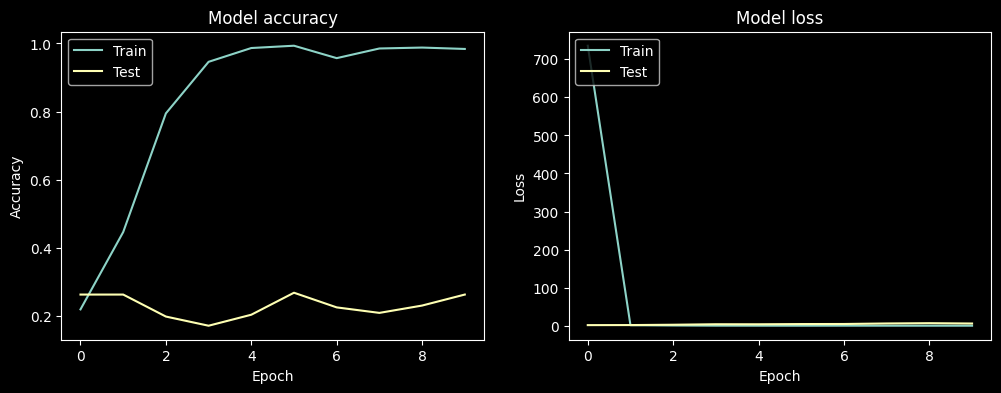

In [58]:
def plot_results(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

plot_results(history)

### Train-test sur 15 races

In [59]:
NB_BREEDS = 15

In [67]:
uri_list_2 =ds_img.index.values[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]
X_2 = preprocessing(uri_list_2, (300,300))
y_2 = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

# Convert data in numpy array
y_2 = np.array(y_2)

# Dans un modèle CNN, les labels doivent être numériques. Il faut les encoder.
encoder_2 = LabelEncoder()
encoder_2.fit(y_2)
y_2 = encoder_2.transform(y_2)

In [68]:
#Séparation jeux entraînement/test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2,shuffle=True, random_state=42)

# Passage des X et y de int en categ
y_train_encoded_2 = to_categorical(y_train_2, num_classes=NB_BREEDS)
y_test_encoded_2 = to_categorical(y_test_2, num_classes=NB_BREEDS)

In [77]:
model_2 = create_model(NB_BREEDS)
history_2 = model_2.fit(X_train_2, y_train_encoded_2, epochs=10, validation_data=(X_test_2, y_test_encoded_2))

Epoch 1/10
64/64 [==============================] - 46s 699ms/step - loss: 475.7958 - accuracy: 0.0810 - val_loss: 2.7062 - val_accuracy: 0.0706
Epoch 2/10
64/64 [==============================] - 47s 733ms/step - loss: 2.6975 - accuracy: 0.1001 - val_loss: 2.7054 - val_accuracy: 0.0725
Epoch 3/10
64/64 [==============================] - 47s 726ms/step - loss: 2.5542 - accuracy: 0.1880 - val_loss: 2.8906 - val_accuracy: 0.1020
Epoch 4/10
64/64 [==============================] - 48s 742ms/step - loss: 1.8529 - accuracy: 0.4880 - val_loss: 3.2524 - val_accuracy: 0.1059
Epoch 5/10
64/64 [==============================] - 46s 715ms/step - loss: 1.0451 - accuracy: 0.7231 - val_loss: 5.6115 - val_accuracy: 0.1235
Epoch 6/10
64/64 [==============================] - 42s 664ms/step - loss: 0.4815 - accuracy: 0.8915 - val_loss: 6.0051 - val_accuracy: 0.1176
Epoch 7/10
64/64 [==============================] - 42s 660ms/step - loss: 0.6319 - accuracy: 0.8763 - val_loss: 4.6694 - val_accuracy: 0.09

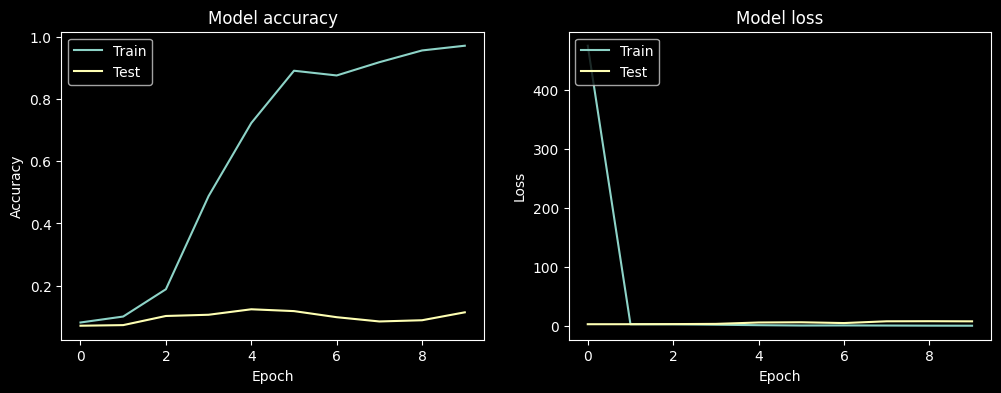

In [78]:
plot_results(history_2)

### Data Augmentation sur 5 races

In [79]:
uri_list_15_3 =ds_img.index.values[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]
X_3 = preprocessing(uri_list_15_3, (300,300))
y_3 = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

# Convert data in numpy array
y_3 = np.array(y_3)

# Dans un modèle CNN, les labels doivent être numériques. Il faut les encoder.
encoder_3 = LabelEncoder()
encoder_3.fit(y_3)
y_3 = encoder_3.transform(y_3)

In [80]:
#Séparation jeux entraînement/test
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2,shuffle=True, random_state=42)

# Passage des X et y de int en categ
y_train_encoded_3 = to_categorical(y_train_3, num_classes=NB_BREEDS)
y_test_encoded_3 = to_categorical(y_test_3, num_classes=NB_BREEDS)

Observer cb d'images sont créées ; comment le Data Augmentation se passe (transformationd es images existantes et/ou création de nouvelles)

In [81]:
# Data augmentation

datagen.fit(X_train_3)

Transfer Leanrning : 
VGG16
Inception
SI temps : Resnet

In [83]:
model_3 = create_model(NB_BREEDS)
history_3 = model_3.fit(X_train_3, y_train_encoded_3, epochs=10, validation_data=(X_test_3, y_test_encoded_3))

Epoch 1/10
64/64 [==============================] - 50s 768ms/step - loss: 205.5220 - accuracy: 0.0687 - val_loss: 2.7085 - val_accuracy: 0.0647
Epoch 2/10
64/64 [==============================] - 87s 1s/step - loss: 2.6981 - accuracy: 0.1011 - val_loss: 2.7063 - val_accuracy: 0.0843
Epoch 3/10
64/64 [==============================] - 45s 699ms/step - loss: 2.5635 - accuracy: 0.1689 - val_loss: 2.7346 - val_accuracy: 0.0902
Epoch 4/10
64/64 [==============================] - 43s 674ms/step - loss: 2.0355 - accuracy: 0.3490 - val_loss: 3.0511 - val_accuracy: 0.0804
Epoch 5/10
64/64 [==============================] - 42s 663ms/step - loss: 1.2279 - accuracy: 0.6259 - val_loss: 3.8450 - val_accuracy: 0.0961
Epoch 6/10
64/64 [==============================] - 42s 663ms/step - loss: 0.6063 - accuracy: 0.8301 - val_loss: 5.4561 - val_accuracy: 0.1137
Epoch 7/10
64/64 [==============================] - 42s 657ms/step - loss: 0.2796 - accuracy: 0.9313 - val_loss: 7.0377 - val_accuracy: 0.1157


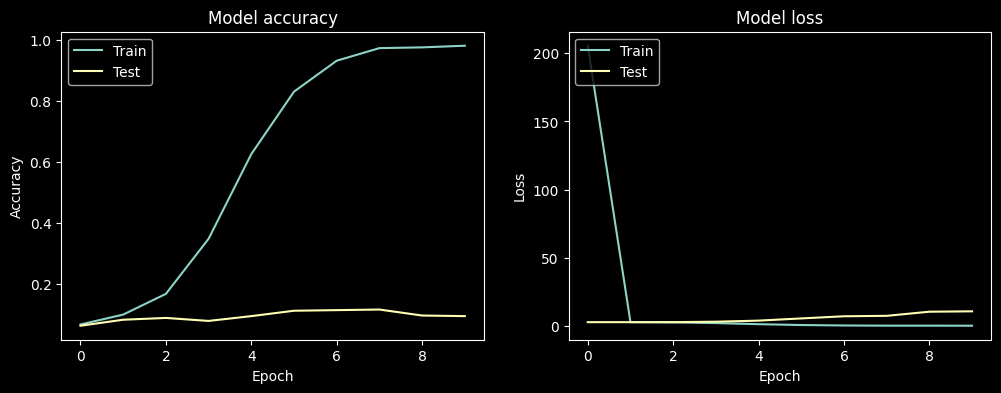

In [84]:
plot_results(history_3)

In [ ]:
# End code

__Pour faire tout cela, je crée une fonction avec les couches du modèle, et je lui passe les paramètres avec un RandomizedSearch.__

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Fonction pour créer le modèle, nécessaire pour KerasClassifier
def create_model(optimizer='adam', activation='relu', nb_filters=32, kernel_size=3):
    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size=(kernel_size, kernel_size), activation=activation, input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dense(len(list_breeds), activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Créer le modèle avec KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Définir les paramètres de la grille de recherche
optimizer = ['SGD', 'Adam']
activation = ['relu', 'tanh', 'sigmoid']
nb_filters = [32, 64, 128]
kernel_size = [3, 5]
epochs = [10, 20, 30]

param_grid = dict(optimizer=optimizer, activation=activation, nb_filters=nb_filters, kernel_size=kernel_size, epochs=epochs)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, scoring=['accuracy', 'neg_log_loss'], refit='accuracy')

In [ ]:
# ECHEC DU RANDOMIZEDSEARCH

# Fonction pour créer le modèle, nécessaire pour KerasClassifier
def create_model_func(nb_filters, kernel_size):
    def create_model(optimizer='adam', activation='relu'):
        model = Sequential()
        model.add(Conv2D(nb_filters, kernel_size=(kernel_size, kernel_size), activation=activation, input_shape=(64, 64, 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation=activation))
        model.add(Dense(len(list_breeds), activation='softmax'))
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    return create_model


# Créer le modèle avec KerasClassifier
model = KerasClassifier(build_fn=create_model_func(32,3), verbose=0)

# Définir les paramètres de la grille de recherche
optimizer = ['SGD', 'Adam']
activation = ['relu', 'tanh', 'sigmoid']
nb_filters = [32, 64, 128]
kernel_size = [3, 5]
epochs = [10, 20, 30]

param_grid = dict(optimizer=optimizer, activation=activation, nb_filters=nb_filters, kernel_size=kernel_size, epochs=epochs)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, scoring=['accuracy', 'neg_log_loss'], refit='accuracy')

# Exécuter la recherche sur grille
grid_result = grid.fit(X_train, y_train)

# Résumer les résultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))